In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as td
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [7]:
class prior(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        
    def forward(self):
    #returns the prior distribution - this class is probably unnecessary since we're not going to mess with the prior.
    
        return td.Normal(torch.zeros(self.dim), torch.eye(self.dim))

    

<h1><center> The Diffusion Process </center> </h1>

In [8]:
class diffusion_process(nn.Module):
    
    def __init__(self, time_steps, noise_schedule):
        super().__init__()
        
        self.gamma = noise_schedule   #could be learned (Kingma et al), but is often fixed - we'll start with fixed.
        self.T = time_steps
        
        
        
    def forward(self, x, t, inc_dist = False):
    #starting with an input image x and a timestep t between 0 and 1, we return a sample z_{t} from q(z_t | x) and the corresponding log probability.
    
        var_t = self.gamma(t)
        alpha_t = (1- var_t)**.5 #we'll always use the 'variance preserving' architecture for our diffusion processes.
        cond_t = td.Normal(alpha_t*x, var_t)
        z_t = cond_t.rsample()
        log_prob = cond_t.log_prob(z_t)
        
        if inc_dist:
            return z_t, log_prob
        else:
            return z_t
    
    
        
        
        

**An Example:**

In [9]:
#100 time steps, with variances starting at 1e-2 and increasing by 1e-2 at each step.
class toy_noise_schedule(nn.Module):
    def __init__(self):
        super().__init__()
            
    def forward(self, t):
        return (t+1)*1e-2
            
            
toy_schedule = toy_noise_schedule()                    
toy_diffusion = diffusion_process(100, toy_schedule)

In [34]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

cifar_train = datasets.CIFAR10(root = './data', train = True, download = True, transform = ToTensor())
cifar_test = datasets.CIFAR10(root = './data', train = False, download = True, transform = ToTensor())

mnist_train = datasets.MNIST(root = './data', train = True, download = True, transform = ToTensor())
mnist_test = datasets.MNIST(root = './data', train = True, download = True, transform = ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

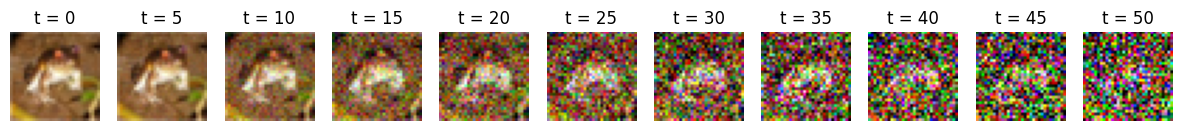

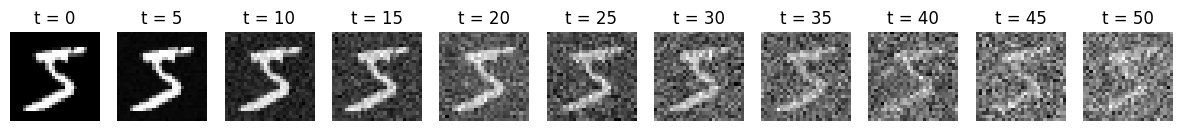

In [35]:
im, label = cifar_train[0]

images = [im]


for t in range(10):
    images.append(toy_diffusion(im, 5*t))


figure = plt.figure(figsize=(15,15))


for i in range(11):
    figure.add_subplot(1,11,i+1)
    plt.axis("off")
    plt.title("t = {}".format(5*i))
    plt.imshow(images[i].numpy().transpose(1,2,0), cmap = "gray")
    

    
im, label = mnist_train[0]

images = [im]


for t in range(10):
    images.append(toy_diffusion(im, 5*t))


new_figure = plt.figure(figsize=(15,15))


for i in range(11):
    new_figure.add_subplot(1,11,i+1)
    plt.axis("off")
    plt.title("t = {}".format(5*i))
    plt.imshow(images[i].numpy().transpose(1,2,0), cmap = "gray")

    
    


Looks pretty good!

<h1> <center> Denoising Neural Network </center> </h1>
I think in general, the neural networks used in diffusion models are pretty sophisticated - however, we could likely start with something pretty simple and try to get a model that can at least learn something. Once we get something off the ground and running, we could try to introduce more sophisticated denoising networks.

In [24]:
class denoise_net(nn.Module):
    def __init__(self, dif_proc, net):
        super().__init__()
        self.dif_proc = dif_proc
        self.net = net
        
    def forward(self, z_t, t):
        #should take in a pair (z_t, t) and spit out epsilon(z_t, t)
        #epsilon should be a U-net neural network, as in Ho et al.
        return self.net(z_t, t)
        
    def denoise(self, z_t, t):
        #should take in a pair (z_t, t) and spit out the neural networks reconstruction of x from z_t
        var_t = self.dif_proc.gamma(t) #Equation 3
        alpha_t = (1-var_t)**.5
                
        return (z_t - var_t*self.net(z_t,t))/alpha_t #Equation 10
        
    

**Silly Example to Check Code Compiles:**

In [30]:
class toy_denoising_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(3073, 3072)
        torch.nn.init.xavier_uniform_(self.layer_1.weight)
        
    def forward(self, z_t, t):
        #z_t is a tensor of size [1, 28, 28] (for this example we're using a single image from MNIST) and t is a scalar. 
        z_t = z_t.view(3072)      
        z_t = torch.cat((z_t, t), dim=0)
        
        x_rec = self.layer_1(z_t)
        x_rec = torch.tanh(x_rec)
        
        x_rec = x_rec.view(3,32,32)
        
        return x_rec
        
        
    

In [31]:
toy_net = toy_denoising_net()
toy_denoise_net = denoise_net(toy_diffusion, toy_net)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

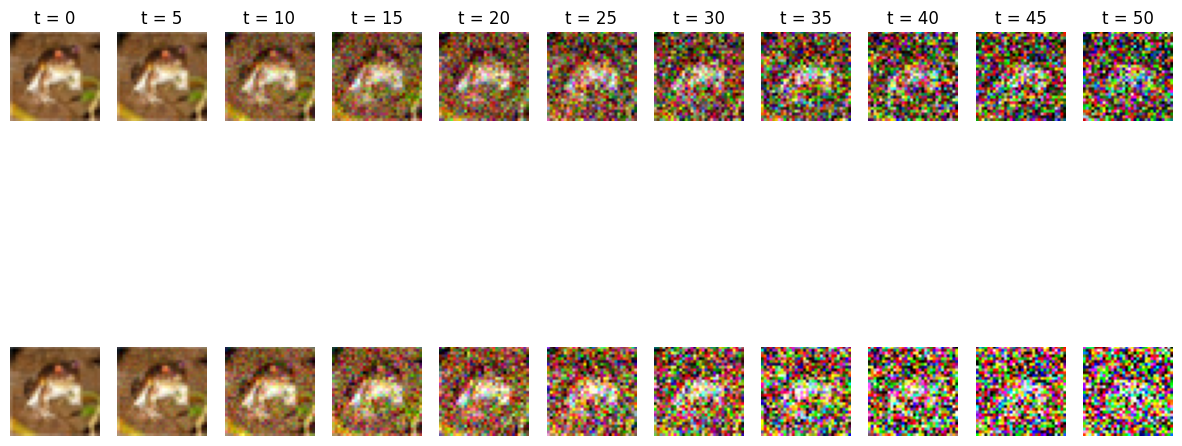

In [33]:
# So we can repeat the above diffusion process using our denoising net (which includes a diffusion process)
images = [im]

for t in range(10):
    images.append(toy_denoise_net.dif_proc(im, 5*t))
    

figure = plt.figure(figsize=(15,15))

for i in range(11):
    figure.add_subplot(2,11,i+1)
    plt.axis("off")
    plt.title("t = {}".format(5*i))
    plt.imshow(images[i].numpy().transpose(1,2,0), cmap = "gray")
    
    
denoised_images = [im]

for t in range(10):
    denoised_images.append(toy_denoise_net.denoise(images[t+1], torch.tensor([5*(t+1)])))
    
for i in range(11):
    figure.add_subplot(1, 11, i+1)
    plt.axis("off")
    plt.title("")
    plt.imshow(denoised_images[i].detach().numpy().transpose(1,2,0), cmap = "gray")

    

Obviously nothing happens, but the code at least compiles. As of now, the 'denoising neural network' is pretty silly, and in fact adds noise to the image.

<h1><center> The Diffusion Model </center></h1>

In [40]:
class vd_model(nn.Module):
    
    def __init__(self, dif_proc, denoiser, prior, time_steps):
        super().__init__()
        
        self.prior = prior
        self.dif_proc = dif_proc
        self.denoiser = denoiser 
        self.T = time_steps
        
        
        
    def sample(self, z_t, i):
    #given a latent value z_t and an index i, generate a sample z_{s(i)} from the model distribution p(z_{s(i)} | z_t, x) where z_t = z_{t(i)}.
        if i < 1:
            raise ValueError("The index of the sample must be positive.")
    
        t = i/T
        s = (i-1)/T
        
        var_t = self.dif_proc.noise_schedule(t)
        alpha_t = (1-var_t)**.5
        
        var_s = self.dif_proc.noise_schedule(s)
        alpha_s = (1-var_s)**.5
        
        alpha_ts = alpha_t/alpha_s
        var_ts = var_t - alpha_t|s**2 * var_s
        
        mean = ((alpha_t|s * var_s)/var_t) * z_t + alpha_s * var_t|s/var_t * self.denoiser(z_t)
        variance = var_t|s*var_s/var_t
        
        distribution = td.Normal(mean, variance)
        
        return td.rsample(distribution)
        
        
        
        
    def generative_dist(self, z_0):
    #given a latent value z_0, return the model distribution p(x | z_0).
        a = 0
        
        
    def forward(self, x):
        #The forward function computes a Monte-Carlo estimate of the variational lower bound, following Kingma et al's paper. This consists of 
        #the KL divergence between the prior and the diffusion distribution q(z_1| x), the reconstruction loss (RL), and the diffusion loss.
    
    
        #KL divergence
        z_1, q_log_prob = self.dif_proc(x, 1)
        p_z1 = self.prior()
        p_log_prob = p_z1.log_prob(z_1)
        
        KL = q_log_prob - p_log_prob
    
        #reconstruction loss
        z_0 = self.dif_proc(x, 0, inc_dist = False)
        gen_dist = self.generative_dist(z_0)
        
        RL = gen_dist.log_prob(x)
        
        #Diffusion loss - note that if the noise is constant, this vanishes
        k = td.Uniform(1, self.T).rsample()
        s_k = (k-1)/T
        t_k = k/T
        epsilon = self.prior.rsample()
        z_k = self.dif_proc(x, t_k)        
        e_norm = (epsilon - self.denoiser(z_k, t_k))**2
        
        L_T = (T/2)*(exp(self.dif_proc.gamma(s_k) - self.dif_proc.gamma(t_k)) -1) * e_norm
        
        return KL + RL + L_T
        
        
        
    
    